<a href="https://colab.research.google.com/github/ranjan2829/Quant/blob/main/Quant_%26_Algorithmic_trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unsupervised Learning on s&p 500 stocks


In [ ]:
pip install pandas_ta


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=c1e497879406df681ea171672cb34ed5fb5b7971a1b33c33cd4cfbf61d879d4c
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")



[*********************102%%***********************]  513 of 503 completed

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716064   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024632   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807262   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZION      1586100.0  
           ZTS       1463200.0  

[993179 rows x 6 columns]

In [ ]:
df['garman_volatility'] = ((np.log(df['high']) - np.log(df['low']))**2) / 2 - (2 * np.log(2) - 1) * (np.log(df['close']) - np.log(df['open'])**2)


In [ ]:
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716064   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024632   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807262   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_volatility  
date       ticker                                  
2015-09-29 A         2252400.0           3.393071  
           AAL       7478800.0           3.771667  
           AAPL    293461600.0           3.032649  
           ABBV     12842800.0           4.563807  
           ABT      12287500.0           3.783811  
...                        ...                ...  
2023-09-26 YUM       1500600.0           7.120771  
           ZBH       3610500.0           6.929784  
           ZBRA       355400.0           9.259367  
           ZION      1586100.0           3.429028  
           ZTS       1463200.0           8.341145  

[993179 rows x 7 columns]

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [ ]:

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

<Axes: xlabel='date'>

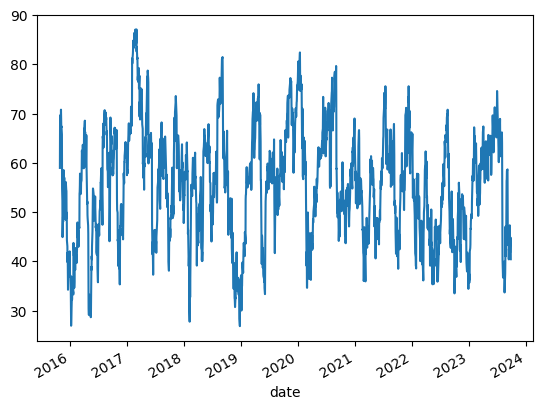

In [ ]:
df.xs('AAPL',level=1)['rsi'].plot()

In [ ]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])


<Axes: xlabel='date'>

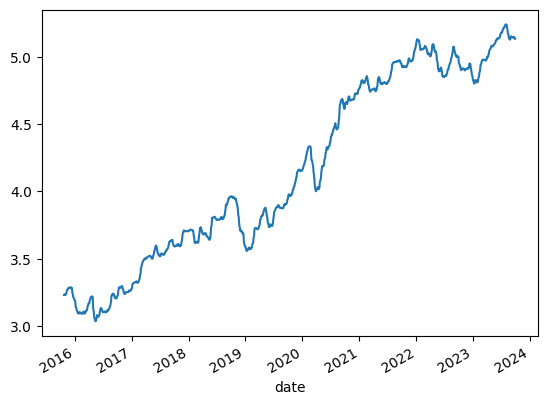

In [ ]:
df.xs('AAPL',level=1)['bb_low'].plot()

<Axes: xlabel='date'>

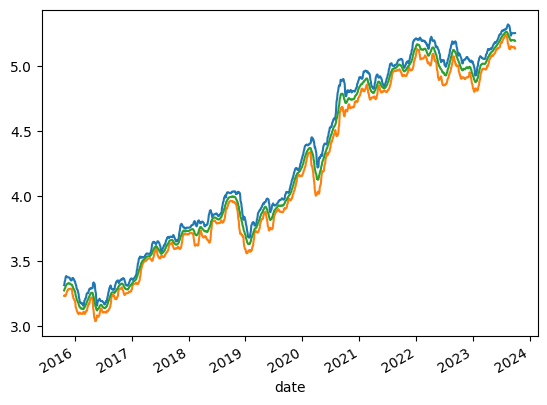

In [ ]:
df.xs("AAPL",level=1)['bb_high'].plot()
df.xs('AAPL',level=1)['bb_low'].plot()
df.xs("AAPL",level=1)['bb_mid'].plot()

In [ ]:
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716064   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024632   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807262   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_volatility  garman_klass_vol  \
date       ticker                                                     
2015-09-29 A         2252400.0           3.393071         -0.000926   
           AAL       7478800.0           3.771667         -0.000443   
           AAPL    293461600.0           3.032649         -0.005441   
           ABBV     12842800.0           4.563807         -0.049280   
           ABT      12287500.0           3.783811         -0.008237   
...                        ...                ...               ...   
2023-09-26 YUM       1500600.0           7.120771          0.000037   
           ZBH       3610500.0           6.929784          0.000161   
           ZBRA       355400.0           9.259367          0.000133   
           ZION      1586100.0           3.429028          0.000292   
           ZTS       1463200.0           8.341145          0.000075   

                         rsi    bb_low    bb_mid   bb_high  
date       ticker                                           
2015-09-29 A             NaN       NaN       NaN       NaN  
           AAL           NaN       NaN       NaN       NaN  
           AAPL          NaN       NaN       NaN       NaN  
           ABBV          NaN       NaN       NaN       NaN  
           ABT           NaN       NaN       NaN       NaN  
...                      ...       ...       ...       ...  
2023-09-26 YUM     36.057193  4.821521  4.851489  4.881456  
           ZBH     31.893251  4.749948  4.789615  4.829283  
           ZBRA    29.494977  5.400991  5.539167  5.677342  
           ZION    46.707775  3.527329  3.582765  3.638202  
           ZTS     42.623482  5.161192  5.220007  5.278822  

[993179 rows x 12 columns]

In [ ]:
def compute_atr(stock):
  atr=pandas_ta.atr(high=stock['high'],
                    low=stock['low'],
                    close=stock['close'],
                    length=14)
  return atr.sub(atr.mean()).div(atr.std())


In [ ]:
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

<Axes: xlabel='date'>

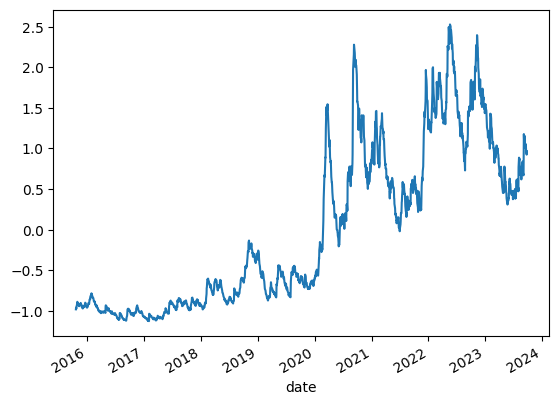

In [ ]:
df.xs('AAPL',level=1)['atr'].plot()

In [ ]:
def compute_macd(close):
  macd=pandas_ta.macd(close=close,length=20).iloc[:,0]
  return macd.sub(macd.mean()).div(macd.std())


In [ ]:
df['macd']=df.groupby(level=1,group_keys=False)['adj close'].apply(compute_macd)

<Axes: xlabel='date'>

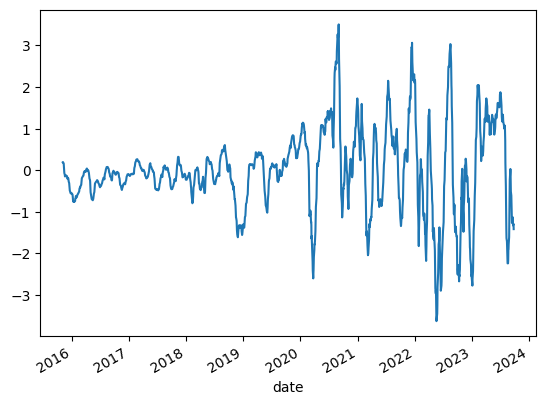

In [ ]:
df.xs('AAPL',level=1)['macd'].plot()

In [ ]:
df['dollar_vol']=(df['adj close']*df['volume'])/1e6

<Axes: xlabel='date'>

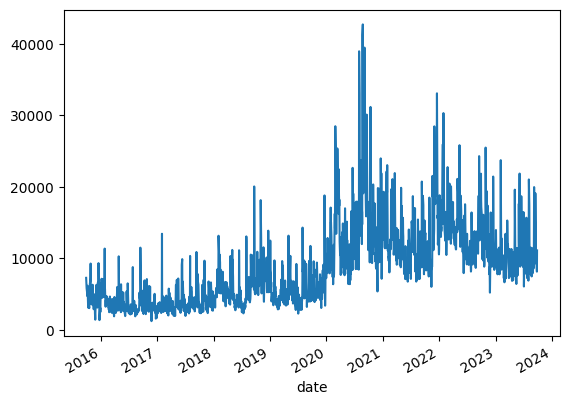

In [ ]:
df.xs('AAPL',level=1)['dollar_vol'].plot()

In [ ]:
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716064   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024632   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807262   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_volatility  garman_klass_vol  \
date       ticker                                                     
2015-09-29 A         2252400.0           3.393071         -0.000926   
           AAL       7478800.0           3.771667         -0.000443   
           AAPL    293461600.0           3.032649         -0.005441   
           ABBV     12842800.0           4.563807         -0.049280   
           ABT      12287500.0           3.783811         -0.008237   
...                        ...                ...               ...   
2023-09-26 YUM       1500600.0           7.120771          0.000037   
           ZBH       3610500.0           6.929784          0.000161   
           ZBRA       355400.0           9.259367          0.000133   
           ZION      1586100.0           3.429028          0.000292   
           ZTS       1463200.0           8.341145          0.000075   

                         rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                      
2015-09-29 A             NaN       NaN       NaN       NaN       NaN   
           AAL           NaN       NaN       NaN       NaN       NaN   
           AAPL          NaN       NaN       NaN       NaN       NaN   
           ABBV          NaN       NaN       NaN       NaN       NaN   
           ABT           NaN       NaN       NaN       NaN       NaN   
...                      ...       ...       ...       ...       ...   
2023-09-26 YUM     36.057193  4.821521  4.851489  4.881456  0.142547   
           ZBH     31.893251  4.749948  4.789615  4.829283 -0.381708   
           ZBRA    29.494977  5.400991  5.539167  5.677342 -0.057389   
           ZION    46.707775  3.527329  3.582765  3.638202 -0.161699   
           ZTS     42.623482  5.161192  5.220007  5.278822  0.651515   

                       macd   dollar_vol  
date       ticker                         
2015-09-29 A            NaN    71.028776  
           AAL          NaN   279.420098  
           AAPL         NaN  7253.215820  
           ABBV         NaN   475.499937  
           ABT          NaN   415.406737  
...                     ...          ...  
2023-09-26 YUM    -1.363696   185.213334  
           ZBH    -0.881067   404.350437  
           ZBRA   -1.600791    79.595386  
           ZION   -0.164625    53.263340  
           ZTS    -1.188278   258.178041  

[993179 rows x 15 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [82]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_vol', 'volume', 'open',
                                                          'high', 'low', 'close']]



In [83]:
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716064   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024632   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807262   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_volatility  garman_klass_vol  \
date       ticker                                                     
2015-09-29 A         2252400.0           3.393071         -0.000926   
           AAL       7478800.0           3.771667         -0.000443   
           AAPL    293461600.0           3.032649         -0.005441   
           ABBV     12842800.0           4.563807         -0.049280   
           ABT      12287500.0           3.783811         -0.008237   
...                        ...                ...               ...   
2023-09-26 YUM       1500600.0           7.120771          0.000037   
           ZBH       3610500.0           6.929784          0.000161   
           ZBRA       355400.0           9.259367          0.000133   
           ZION      1586100.0           3.429028          0.000292   
           ZTS       1463200.0           8.341145          0.000075   

                         rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                      
2015-09-29 A             NaN       NaN       NaN       NaN       NaN   
           AAL           NaN       NaN       NaN       NaN       NaN   
           AAPL          NaN       NaN       NaN       NaN       NaN   
           ABBV          NaN       NaN       NaN       NaN       NaN   
           ABT           NaN       NaN       NaN       NaN       NaN   
...                      ...       ...       ...       ...       ...   
2023-09-26 YUM     36.057193  4.821521  4.851489  4.881456  0.142547   
           ZBH     31.893251  4.749948  4.789615  4.829283 -0.381708   
           ZBRA    29.494977  5.400991  5.539167  5.677342 -0.057389   
           ZION    46.707775  3.527329  3.582765  3.638202 -0.161699   
           ZTS     42.623482  5.161192  5.220007  5.278822  0.651515   

                       macd   dollar_vol  
date       ticker                         
2015-09-29 A            NaN    71.028776  
           AAL          NaN   279.420098  
           AAPL         NaN  7253.215820  
           ABBV         NaN   475.499937  
           ABT          NaN   415.406737  
...                     ...          ...  
2023-09-26 YUM    -1.363696   185.213334  
           ZBH    -0.881067   404.350437  
           ZBRA   -1.600791    79.595386  
           ZION   -0.164625    53.263340  
           ZTS    -1.188278   258.178041  

[993179 rows x 15 columns]

In [86]:
df['dollar_vol'] = (df.loc[:, 'dollar_vol'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

df['dollar_vol_rank'] = (df.groupby('date')['dollar_vol'].rank(ascending=False))

df= df[df['dollar_vol_rank']<150].drop(['dollar_vol', 'dollar_vol_rank'], axis=1)

df

adj close       close        high         low        open  \
date       ticker                                                               
2015-10-14 AAL      41.767200   43.799999   44.500000   43.230000   44.000000   
           AAPL     24.976692   27.552500   27.879999   27.389999   27.822500   
           ABBV     38.180336   53.939999   54.619999   53.570000   54.090000   
           ABT      35.053818   40.720001   41.340000   40.660000   40.970001   
           ACN      90.131058  102.430000  102.949997  101.199997  102.220001   
...                       ...         ...         ...         ...         ...   
2023-09-26 VRTX    351.690002  351.690002  352.540009  349.170013  350.000000   
           VZ       32.300549   32.990002   33.169998   32.810001   32.889999   
           WFC      40.290813   40.650002   41.310001   40.360001   41.049999   
           WMT     161.898697  162.500000  163.539993  162.350006  162.940002   
           XOM     115.355156  116.410004  116.730003  115.370003  115.500000   

                        volume  garman_volatility  garman_klass_vol  \
date       ticker                                                     
2015-10-14 AAL      11125800.0           4.072138         -0.000629   
           AAPL    177849600.0           2.992066         -0.004340   
           ABBV      8727400.0           4.611542         -0.046682   
           ABT       6417200.0           3.893391         -0.009258   
           ACN       2421100.0           6.482602         -0.005972   
...                        ...                ...               ...   
2023-09-26 VRTX       633600.0          10.991137          0.000037   
           VZ       18841600.0           3.363147         -0.000067   
           WFC      15219400.0           3.899785          0.000136   
           WMT       4811900.0           8.054984          0.000011   
           XOM      11805400.0           6.875510          0.000068   

                         rsi    bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                               
2015-10-14 AAL           NaN       NaN       NaN       NaN       NaN       NaN  
           AAPL          NaN       NaN       NaN       NaN       NaN       NaN  
           ABBV          NaN       NaN       NaN       NaN       NaN       NaN  
           ABT           NaN       NaN       NaN       NaN       NaN       NaN  
           ACN           NaN       NaN       NaN       NaN       NaN       NaN  
...                      ...       ...       ...       ...       ...       ...  
2023-09-26 VRTX    52.406728  5.838959  5.859127  5.879295  0.029799  0.027907  
           VZ      42.222474  3.499366  3.531604  3.563843 -1.078816 -0.350385  
           WFC     40.920287  3.709473  3.749849  3.790225 -0.558742 -0.282325  
           WMT     54.722512  5.077929  5.095615  5.113302 -0.196379  0.399459  
           XOM     59.440186  4.704273  4.744375  4.784477  0.601335  1.400623  

[298149 rows x 14 columns]

from matplotlib import pyplot as plt
df['adj close'].plot(kind='hist', bins=20, title='adj close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['close'].plot(kind='hist', bins=20, title='close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['high'].plot(kind='hist', bins=20, title='high')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['low'].plot(kind='hist', bins=20, title='low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='adj close', y='close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='close', y='high', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='high', y='low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='low', y='open', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['adj close'].plot(kind='line', figsize=(8, 4), title='adj close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['close'].plot(kind='line', figsize=(8, 4), title='close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['high'].plot(kind='line', figsize=(8, 4), title='high')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['low'].plot(kind='line', figsize=(8, 4), title='low')
plt.gca().spines[['top', 'right']].set_visible(False)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


from matplotlib import pyplot as plt
_df_0['adj close'].plot(kind='hist', bins=20, title='adj close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['close'].plot(kind='hist', bins=20, title='close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['high'].plot(kind='hist', bins=20, title='high')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['low'].plot(kind='hist', bins=20, title='low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='adj close', y='close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='close', y='high', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='high', y='low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='low', y='open', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['adj close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('adj close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['high']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('high')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['low']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('low')

from matplotlib import pyplot as plt
_df_12['adj close'].plot(kind='line', figsize=(8, 4), title='adj close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['close'].plot(kind='line', figsize=(8, 4), title='close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['high'].plot(kind='line', figsize=(8, 4), title='high')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['low'].plot(kind='line', figsize=(8, 4), title='low')
plt.gca().spines[['top', 'right']].set_visible(False)